<a href="https://colab.research.google.com/github/fadeevie/conv_nn/blob/main/%D0%A4%D0%B0%D0%B4%D0%B5%D0%B5%D0%B2%D0%98%D0%95_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт библиотек

In [ ]:
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch import optim
from torchvision import models
import random
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

random.seed(42)
# torch.manual_seed(42)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = '/content/drive/MyDrive/flowers'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/MyDrive
#%cp -r $FOLDERNAME ../../
#%cd ../../
%cd /content/drive/MyDrive/flowers
#!bash get_datasets.sh
#%cd ../../

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/flowers


In [ ]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок:
dataset = ImageFolder('/content/drive/MyDrive/flowers', transform=prepare_imgs)

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# Создаем список классов на основе названий папок в датасете
classes = os.listdir('/content/drive/MyDrive/flowers')

# Выводим список классов
print(classes)

['dandelion', 'daisy', 'rose', 'tulip', 'sunflower']


In [ ]:
print(len(train_loader))
print(len(test_loader))

108
27


Отображение исходных данных

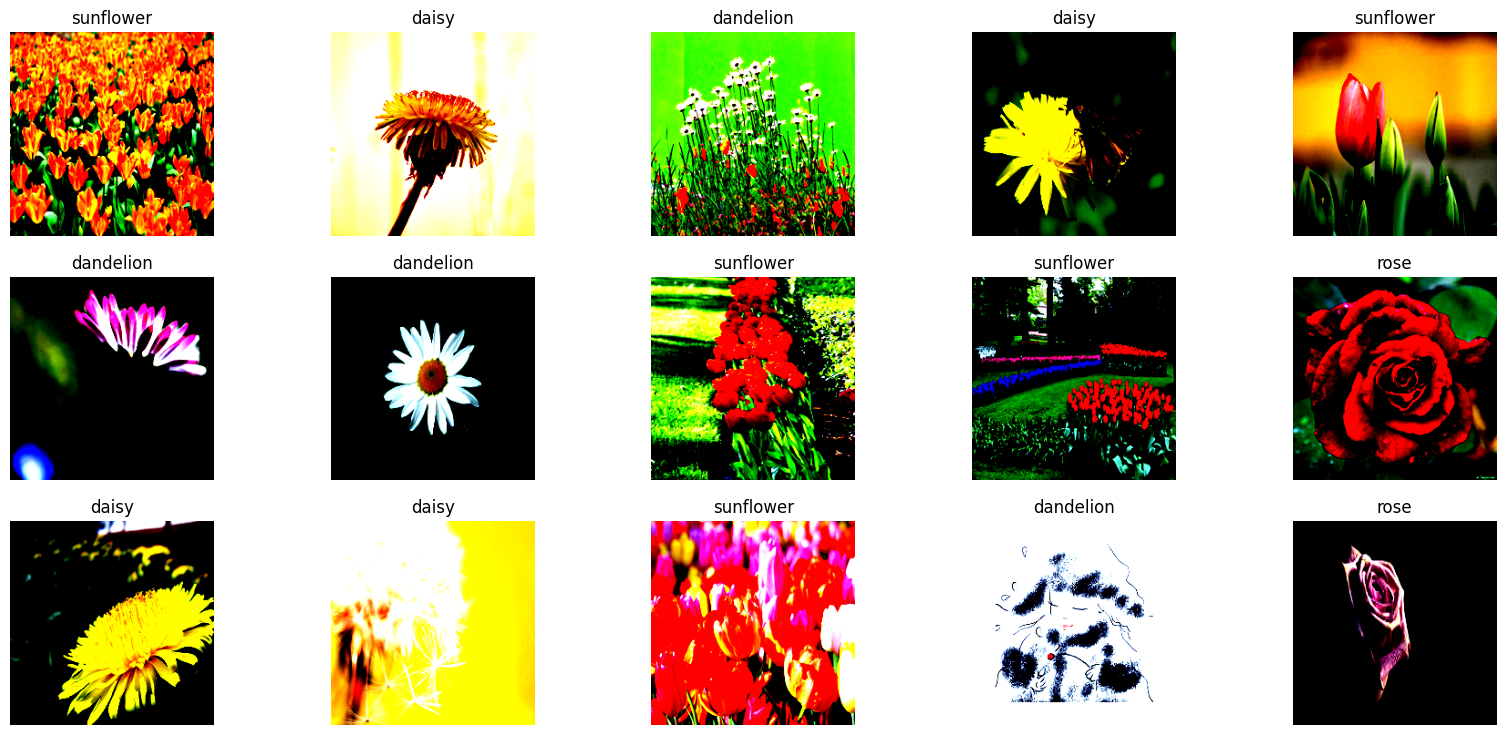

In [ ]:
# Получаем первый батч данных из DataLoader
for images, labels in train_loader:
    # Преобразуем тензоры PyTorch в массивы NumPy для отображения
    images = images.numpy()
    labels = labels.numpy()

    # Создаем фигуру и подграфики для отображения изображений
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 9))

    # Отображаем каждое изображение и соответствующую метку
    for idx, ax in enumerate(axes.flat):
        ax.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])
        ax.axis('off')  # Отключаем оси координат
    break  # Выходим из цикла после отображения первого батча
plt.show()

In [ ]:
first_image, _ = dataset[0]  # Получаем первое изображение из датасета
image_size = first_image.size  # Получаем размеры изображения
print("Размер первого изображения:", image_size)
first_image.shape

Размер первого изображения: <built-in method size of Tensor object at 0x7e30354ecd60>


torch.Size([3, 224, 224])

Определение архитектуры сети ResNet

In [ ]:
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(dataset.classes))
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Определение функции потерь и оптимизатора

In [ ]:
loss_f = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train_accuracy = []
test_accuracy = []
train_losses = []
test_losses = []
num_epochs = 7

model.train()
for epoch in range(num_epochs):
  running_loss = 0
  correct = 0
  total = 0
  for batch in tqdm(train_loader):
    image_batch, label_batch = batch

    # обнулениие градиента
    optimizer.zero_grad()

    y_pred = model(image_batch)
    loss = loss_f(y_pred, label_batch)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    predict = torch.argmax(y_pred, dim=1)
    correct += (predict == label_batch).sum().item()
    total += label_batch.size(0)

  epoch_train_accuracy = 100 * correct / total
  train_accuracy.append(epoch_train_accuracy)

  epoch_loss = running_loss / len(train_loader)
  train_losses.append(epoch_loss)

  model.eval()

  correct = 0
  total = 0
  test_loss = 0

  with torch.no_grad():
    for batch in tqdm(test_loader):
      image_batch, label_batch = batch

      output = model(image_batch)
      predict = torch.argmax(output, dim=1)

      total += label_batch.size(0)
      correct += (predict == label_batch).sum().item()
      test_loss += loss_f(output, label_batch).item()
  epoch_test_accuracy = 100 * correct / total
  test_accuracy.append(epoch_test_accuracy)
  test_loss /= len(test_loader)
  test_losses.append(test_loss)

  print("epoch {} - loss: {:.3f}, train_accuracy: {:.2f}%, test_accuracy: {:.2f}%".format(epoch, running_loss / len(train_loader), epoch_train_accuracy, epoch_test_accuracy))


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


epoch 0 - loss: 0.693, train_accuracy: 75.73%, test_accuracy: 91.20%


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


epoch 1 - loss: 0.275, train_accuracy: 90.91%, test_accuracy: 89.00%


100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


epoch 2 - loss: 0.181, train_accuracy: 93.54%, test_accuracy: 91.20%


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


epoch 3 - loss: 0.120, train_accuracy: 95.95%, test_accuracy: 92.82%


100%|██████████| 27/27 [00:50<00:00,  1.88s/it]


epoch 4 - loss: 0.067, train_accuracy: 97.91%, test_accuracy: 91.78%


100%|██████████| 27/27 [00:49<00:00,  1.82s/it]


epoch 5 - loss: 0.036, train_accuracy: 98.93%, test_accuracy: 91.32%


100%|██████████| 27/27 [00:49<00:00,  1.82s/it]

epoch 6 - loss: 0.066, train_accuracy: 97.54%, test_accuracy: 93.17%


Отображение результатов

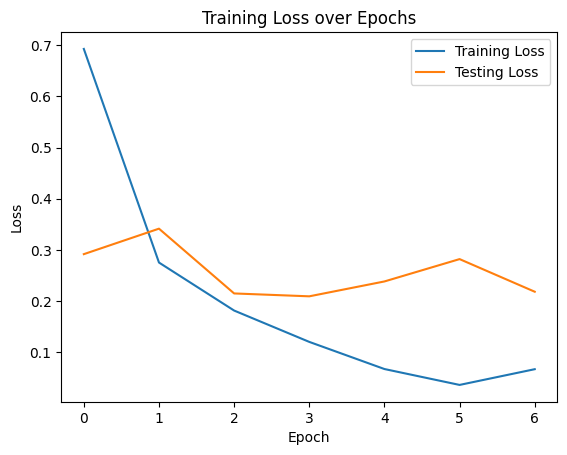

In [ ]:
# Построение графиков
# График потерь на обучающей выборке
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

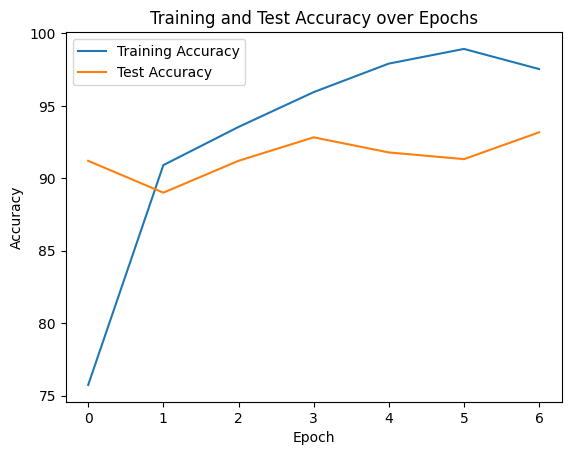

In [ ]:
# График точности на обучающей и тестовой выборках
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()

**Ответы на вопросы**

*Описание архитектуры выбранной предобученой сверточной нейронной сети*

> ResNet (Residual Network) — это сверточная нейронная сеть, которая известна своей глубокой архитектурой и использованием "остаточных блоков" (residual blocks), которые позволяют успешно обучать глубокие сети.
Особенности архитектуры ResNet-18:
1.   Остаточные блоки (Residual blocks): Основным строительным блоком ResNet-18 являются остаточные блоки. Каждый блок состоит из двух сверточных слоев с ядрами 3x3, за которыми следуют пакетная нормализация (batch normalization) и функция активации ReLU. Ключевой идеей является пропуск (skip connection) входа блока и его добавление к выходу блока. Это позволяет градиентам легче проходить через сеть во время обучения.
2.   Начальный слой: Первый слой в ResNet-18 - это сверточный слой с 64 фильтрами размера 7x7 и шагом 2, за которым следуют пакетная нормализация, ReLU и max pooling с ядром 3x3 и шагом 2.
3.   Четыре стадии остаточных блоков: Далее идут 4 стадии, каждая состоит из двух остаточных блоков. Количество фильтров на каждой стадии: 64, 128, 256, 512 соответственно. При переходе на следующую стадию размерность карт признаков уменьшается вдвое с помощью свертки с шагом 2 в первом блоке стадии.
4.   Глобальное среднее пулирование (Global average pooling): После прохождения через все остаточные блоки, применяется глобальное среднее пулирование, чтобы свести каждую карту признаков к одному числу.
5.   Полносвязный слой (Fully connected layer): В конце сети находится один полносвязный слой, выходом которого является вектор, размерность которого равна количеству классов в решаемой задаче классификации.

> В итоге получается сеть с 18 слоями (начальная свертка + 16 сверточных слоев в блоках + 1 полносвязный).























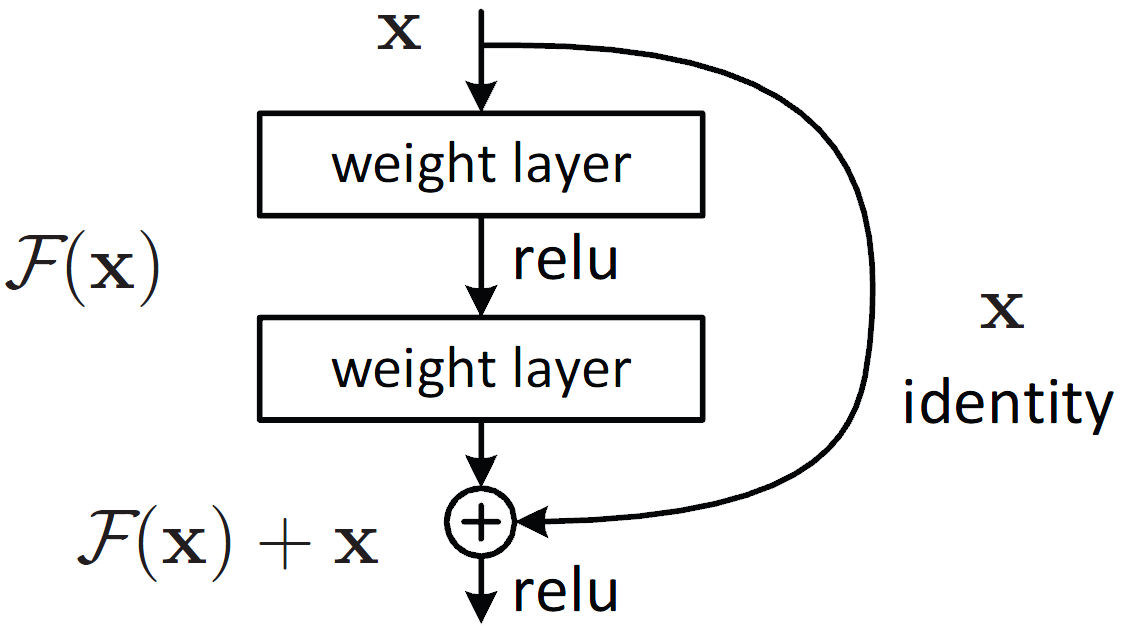

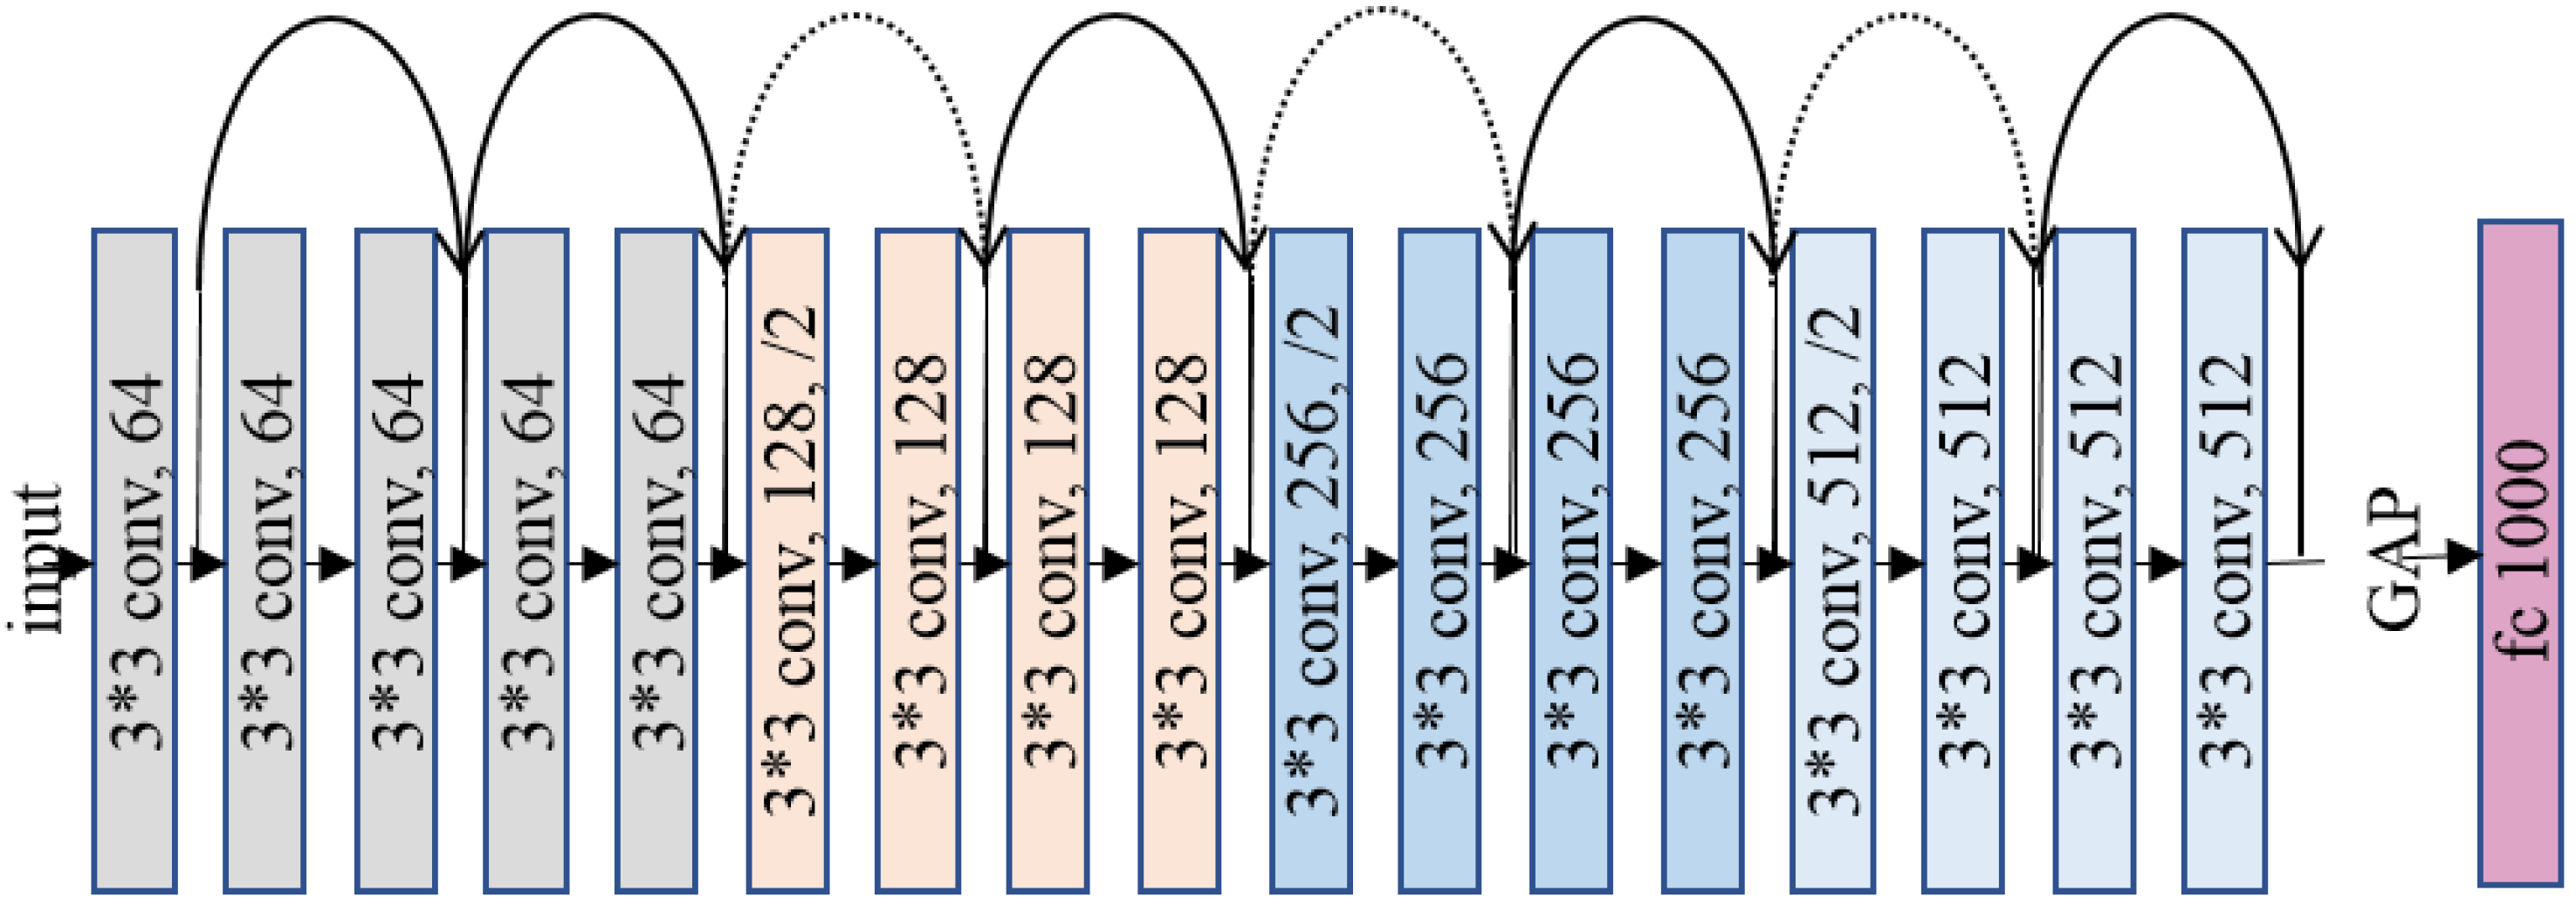

*Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?*

> 1. Прямое распространение (Forward Propagation): Входные изображения пропускаются через несколько сверточных слоев, остаточные блоки и полносвязные слои. Каждый слой выполняет операции свертки, активации и, в случае остаточных блоков, добавляет оригинальный вход к выходу блока.
2.   Обратное распространение (Backpropagation): Происходит подсчет градиентов функции потерь по параметрам модели с помощью алгоритма обратного распространения ошибки.
3.   Обновление весов (Weights Update): Градиенты используются для обновления параметров модели в направлении уменьшения потерь с помощью выбранного оптимизатора (например, стохастический градиентный спуск).

*В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?*

> Сверточные нейронные сети (CNN) обычно состоят из сверточных слоев, pooling-слоев и полносвязных слоев. В то время как полносвязные нейронные сети (DNN) состоят только из полносвязных слоев.

> Также CNN обрабатывают входные данные как трехмерные тензоры (высота, ширина, количество каналов), сохраняя пространственную информацию изображения.

> Сверточные нейронные сети используют специализированные операции, такие как свертка и пулинг, что позволяет им успешно извлекать признаки изображений.